# Data Analysis of the Ford GoBike's trip data

This is a Data Analysis of the Ford GoBike's trip data for public use.

I will investiagte what days of the week that bike trips occur and does the rental pattern differ between user types?

All plots are drawn with [Seaborn](https://seaborn.pydata.org/index.html) library and many uses 
the flexible [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) for categorical variable plotting.


[The Data](https://www.fordgobike.com/system-data) each trip is anonymized and includes:
* Trip Duration (seconds)
* Start Time and Date
* End Time and Date
* Start Station ID
* Start Station Name
* Start Station Latitude
* Start Station Longitude
* End Station ID
* End Station Name
* End Station Latitude
* End Station Longitude
* Bike ID
* User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
* Member Year of Birth
* Member Gender
* [Bike Share For All Trip](https://www.fordgobike.com/pricing/bikeshareforall)


In [1]:
import requests
import os, sys
import pandas as pd
import numpy as np
import zipfile
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
DOWNLOADS_DIR = 'downloads'
DATA_DIR = 'data'

def ensure_dir(file_path=DOWNLOADS_DIR):
    """
    Ensure directory exists or create it.
    :param file_path: directory path
    :return: 
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)

        
def download(*urls):
    """
    Download files from the provided URL.
    :param urls: variable number of URL
    :return: None
    """
    ensure_dir()
    for url in urls:
        url_file = os.path.join(DOWNLOADS_DIR, url.split(os.path.sep)[-1]).replace('-', '_')
        if not os.path.exists(url_file):
            response = requests.get(url, allow_redirects=True)
            with open(url_file, 'wb') as handle:
                handle.write(response.content)
                sys.stdout.write('.')
    sys.stdout.write('\n')


def extract_zip(file, path=DATA_DIR):
    """
    Extract alla files from a zip archive.
    :param file: file name of archive.
    :param path: target directory for unzipped files.
    :return: a list of file names in the archive.
    """
    with zipfile.ZipFile(os.path.join(DOWNLOADS_DIR, file), 'r') as zip_ref:
        zip_ref.extractall(path)
        return zip_ref.namelist()

def rename(file_from, file_to, directory=DOWNLOADS_DIR):
    """
    Rename file in the 
    :param file_from: Existing file to rename
    :param file_to: Target file name
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: None
    """
    source = os.path.join(directory, file_from)
    if os.path.exists(source):
        os.rename(source, os.path.join(directory, file_to))


def file_exists(filename, directory=DOWNLOADS_DIR):
    """
    Check if the file exists in a optional provided directory.
    :param filename: name of file
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: True if file exists.
    """
    return os.path.exists(os.path.join(directory, filename))

## Gather

Define list of tripdata to download and then extract all zip files.
Load all data files into one master dataframe.


In [19]:
download('https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201805-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201806-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201807-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201808-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201809-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201810-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201811-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201812-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201901-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201902-fordgobike-tripdata.csv.zip')

..............


In [20]:
for file in os.listdir(DOWNLOADS_DIR):
    print(file)

201801_fordgobike_tripdata.csv.zip
201812_fordgobike_tripdata.csv.zip
201804_fordgobike_tripdata.csv.zip
201805_fordgobike_tripdata.csv.zip
201901_fordgobike_tripdata.csv.zip
201809_fordgobike_tripdata.csv.zip
201902_fordgobike_tripdata.csv.zip
201803_fordgobike_tripdata.csv.zip
201810_fordgobike_tripdata.csv.zip
201806_fordgobike_tripdata.csv.zip
201808_fordgobike_tripdata.csv.zip
201811_fordgobike_tripdata.csv.zip
201807_fordgobike_tripdata.csv.zip
201802_fordgobike_tripdata.csv.zip


In [22]:
# create a list of data file in the download directory
zip_files = [file for file in os.listdir(DOWNLOADS_DIR) if file.endswith('.zip') and os.path.isfile(os.path.join(DOWNLOADS_DIR, file))]

In [23]:
# extract all zip files into data directory
for file in zip_files:
    extract_zip(file, DATA_DIR)
for file in os.listdir(DATA_DIR):
    print(file)

201802-fordgobike-tripdata.csv
201811-fordgobike-tripdata.csv
201809-fordgobike-tripdata.csv
201806-fordgobike-tripdata.csv
201805-fordgobike-tripdata.csv
201812-fordgobike-tripdata.csv
201801-fordgobike-tripdata.csv
201901-fordgobike-tripdata.csv
201807-fordgobike-tripdata.csv
201808-fordgobike-tripdata.csv
201810-fordgobike-tripdata.csv
201803-fordgobike-tripdata.csv
201804-fordgobike-tripdata.csv
201902-fordgobike-tripdata.csv


In [3]:
# load data source files and make one DataFrame
tripdata_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv') and os.path.isfile(os.path.join(DATA_DIR, file))]
dataframes = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in tripdata_files]

bikeshare_df = pd.concat(dataframes)
del tripdata_files
del dataframes
bikeshare_df.shape

(2239215, 16)

## Assess

Quality issues in data source
* duration_sec - parse as timestamp
* start_time - parse as datetime
* end_time - parse as datetime
* member_birth_year - seems to be optional and several members are over 100 years old
* user_type - Subscriber or Customer, categorical
* member_gender - Three values + NaN, categorical
* bike_share_for_all_trip - Yes and No, categorical

In [12]:
print('Number of unique values in each column:')
for col in bikeshare_df.columns:
    print(f"{col}: {bikeshare_df[col].nunique()}")

Number of unique values in each column:
duration_sec: 17505
start_time: 2239052
end_time: 2239079
start_station_id: 340
start_station_name: 359
start_station_latitude: 385
start_station_longitude: 386
end_station_id: 340
end_station_name: 359
end_station_latitude: 386
end_station_longitude: 387
bike_id: 6126
user_type: 2
member_birth_year: 89
member_gender: 3
bike_share_for_all_trip: 2
duration_log: 17505


In [42]:
bikeshare_df.isnull().sum()

duration_sec                    0
start_time                      0
end_time                        0
start_station_id            12216
start_station_name          12216
start_station_latitude          0
start_station_longitude         0
end_station_id              12216
end_station_name            12216
end_station_latitude            0
end_station_longitude           0
bike_id                         0
user_type                       0
member_birth_year          128703
member_gender              128349
bike_share_for_all_trip         0
dtype: int64

In [14]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 290.4+ MB


In [47]:
print(f"Customer born in range from min: {bikeshare_df['member_birth_year'].min()} - max: {bikeshare_df['member_birth_year'].dropna().max()}")
bikeshare_df.query("member_birth_year < 1910")['member_birth_year'].value_counts()

Customer born in range from min: 1878.0 - max: 2001.0


1900.0    751
1902.0    192
1901.0     44
1888.0     23
1904.0     12
1881.0      5
1909.0      4
1889.0      3
1906.0      2
1903.0      1
1878.0      1
Name: member_birth_year, dtype: int64

In [5]:
bikeshare_df['user_type'].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [6]:
bikeshare_df['member_gender'].unique()

array(['Male', 'Female', nan, 'Other'], dtype=object)

In [13]:
bikeshare_df['bike_share_for_all_trip'].unique()

array(['No', 'Yes'], dtype=object)

## Clean

Define:
* __start_time__ and __end_time__ parse as datetime
* __duration_sec__ parse as timedelta
* __user_type__ and __bike_share_for_all_trip__ - convert to categorical
* __member_gender__ - NaN replace with role Other, convert to categorical

Code and Test

In [4]:
bikeshare_df['start_time'] = pd.to_datetime(bikeshare_df['start_time'])
bikeshare_df['end_time'] = pd.to_datetime(bikeshare_df['end_time'])
bikeshare_df['duration'] = bikeshare_df['duration_sec'].apply(lambda x: timedelta(seconds=x))

In [5]:
bikeshare_df['user_type'] = bikeshare_df['user_type'].astype('category')
bikeshare_df['bike_share_for_all_trip'] = bikeshare_df['bike_share_for_all_trip'].astype('category')
bikeshare_df['member_gender'].fillna('Other', inplace=True)
bikeshare_df['member_gender'] = bikeshare_df['member_gender'].astype('category')
bikeshare_df['member_gender'].unique()

[Male, Female, Other]
Categories (3, object): [Male, Female, Other]

In [6]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 17 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
member_birth_year          float64
member_gender              category
bike_share_for_all_trip    category
duration                   timedelta64[ns]
dtypes: category(3), datetime64[ns](2), float64(7), int64(2), object(2), timedelta64[ns](1)
memory usage: 262.7+ MB


## Exploratory Data Analysis

To start the Exploratory Data Analysis, EDA, I will leverage one of the powerful capabilities that the Seaborn library provides to plot multivariate pairwise relationships of the bikeshare dataset.

/Users/marcusholmgren/code/pyvirtual/mlvenv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/marcusholmgren/code/pyvirtual/mlvenv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


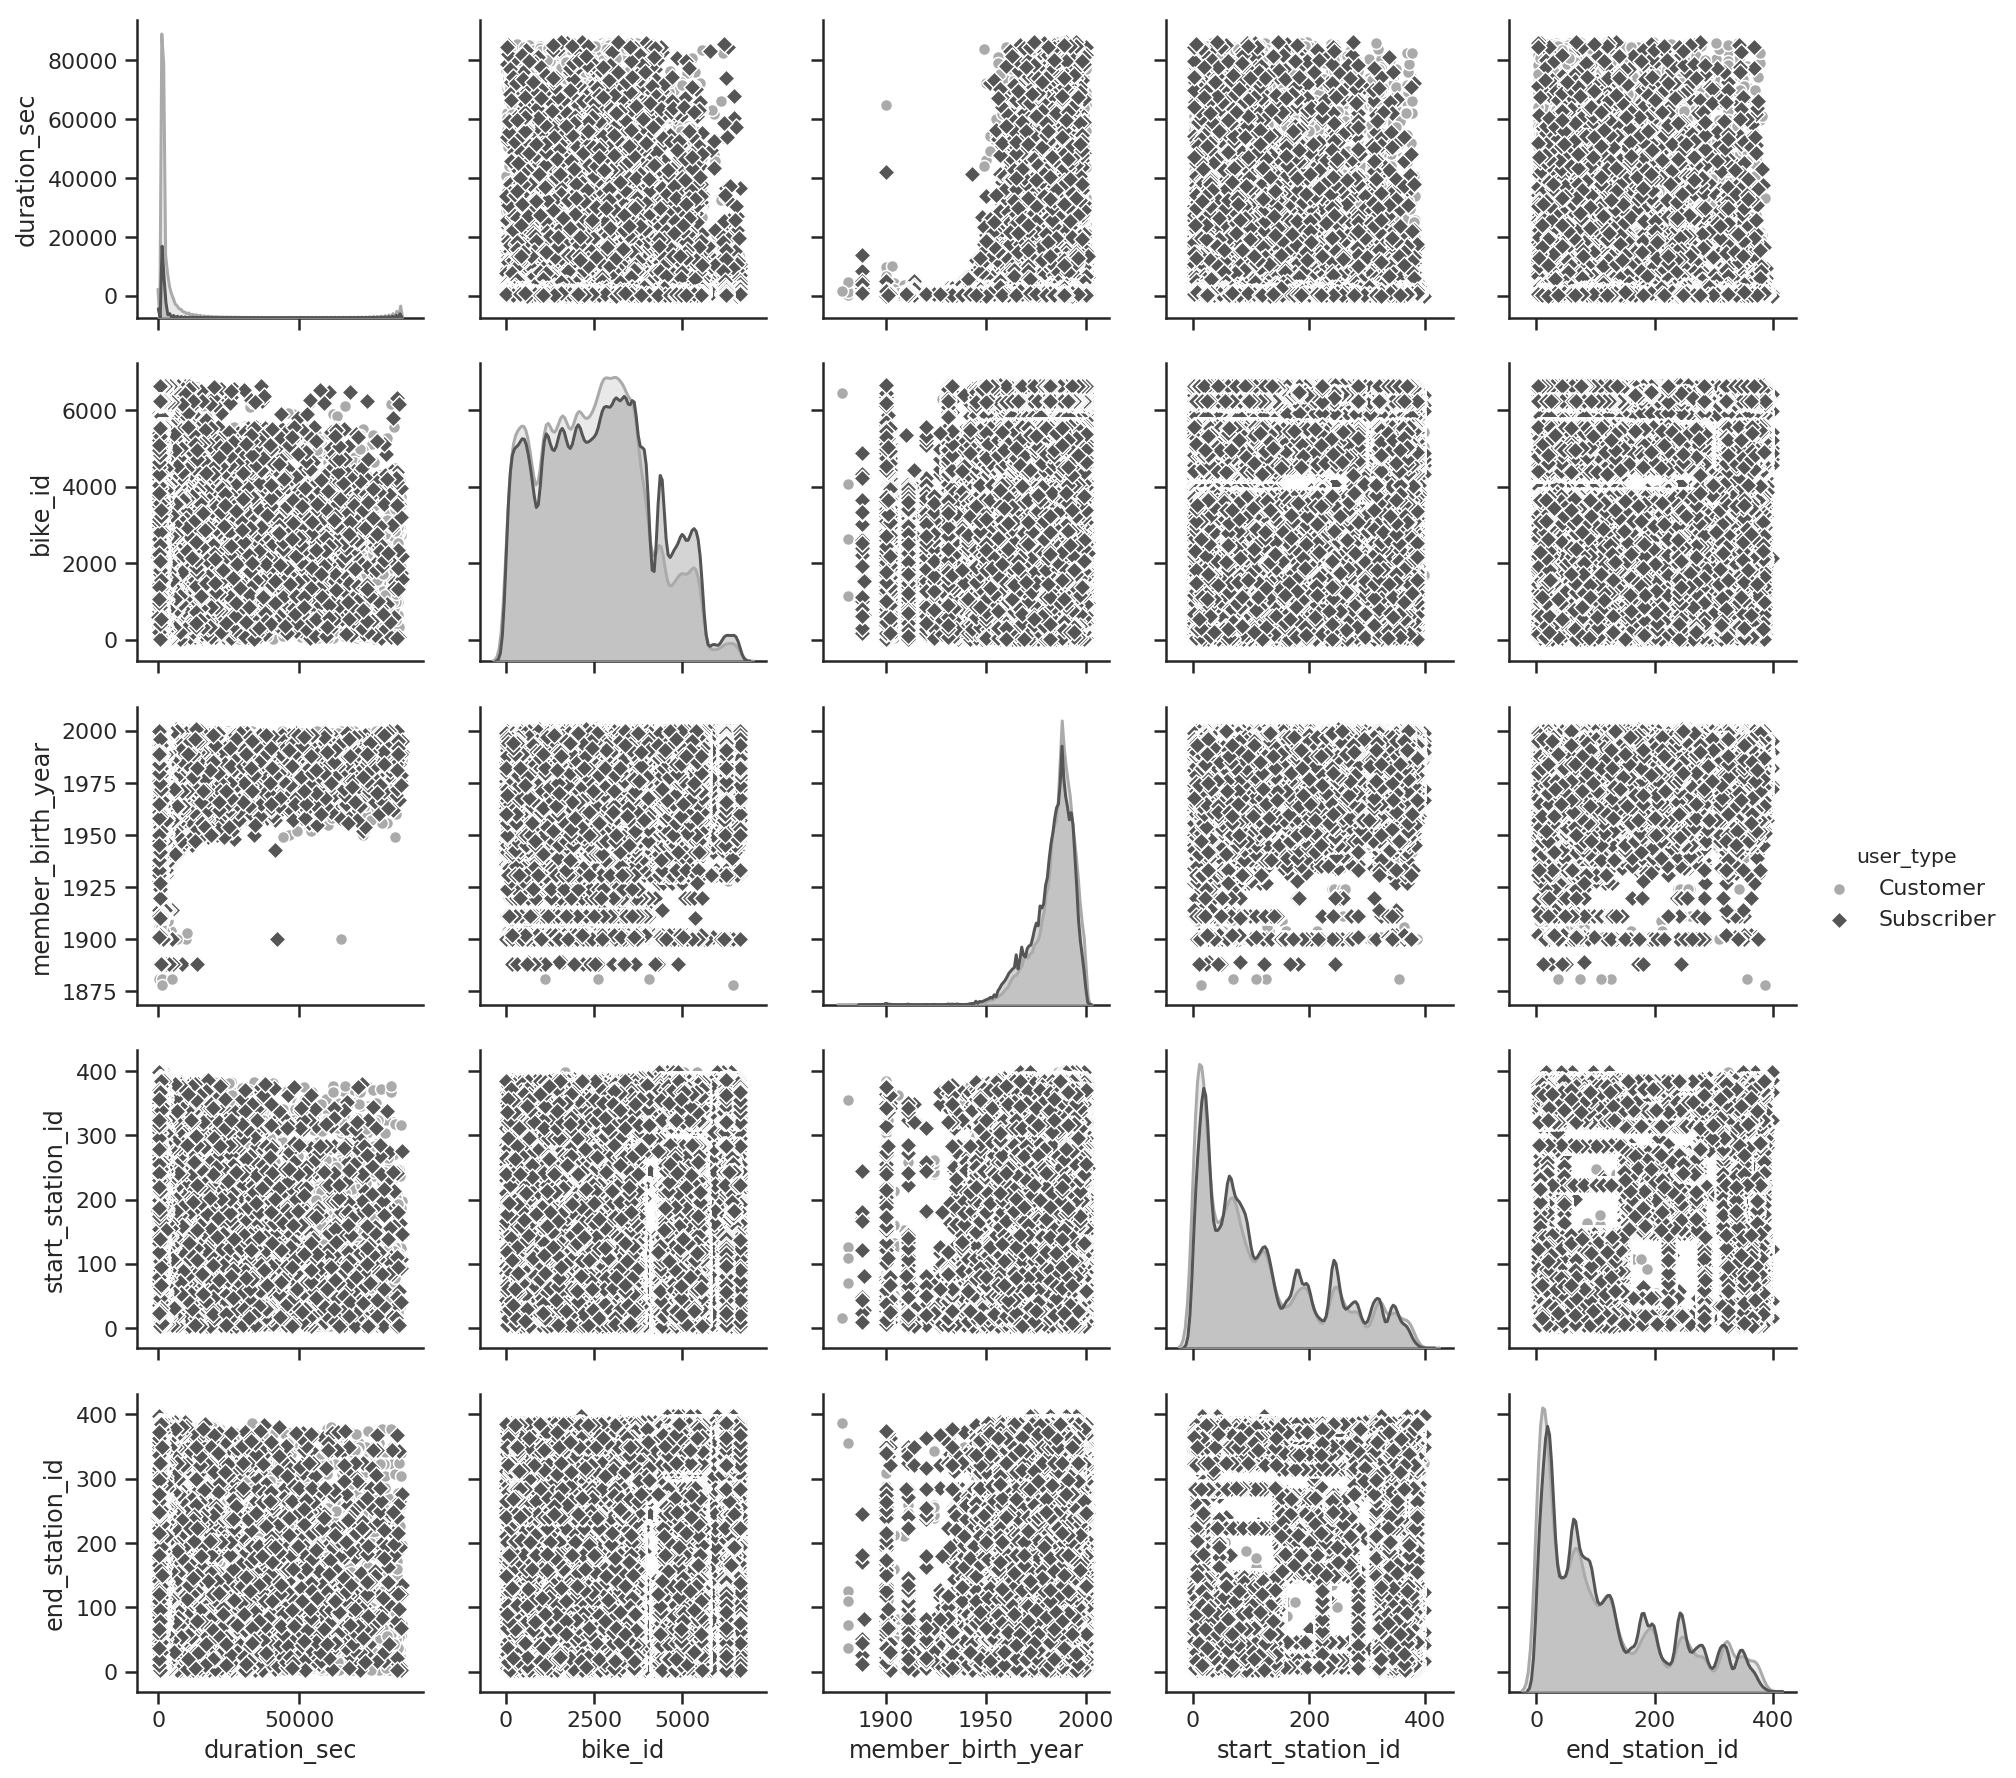

In [7]:
columns = ['duration_sec', 'bike_id', 'member_birth_year', 'start_station_id', 'end_station_id']
sns.pairplot(bikeshare_df, 
             hue='user_type', 
             palette='binary', 
             markers=['o', 'D'], 
             vars=columns, 
             diag_kind='kde');

The pairplot is really busy and 
The pairplot reveales that bike trip duration have a long tail of extreme values.
Member birth year also have a long tail of persons born as early as late 1800 up too younger persons born 2000 or later.

# 1. Exploring duraction of bike rentals

## 1.1. Univariate Exploration

Start with exploring the __duration_sec__ variable

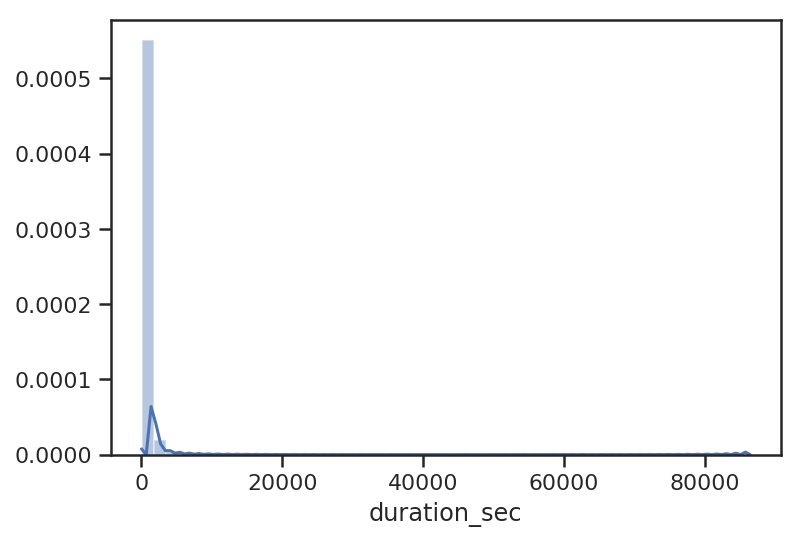

In [11]:
# plot both a kernel density estimate and histogram with default parameters
sns.distplot(bikeshare_df['duration_sec']);

In [58]:
# extrat the lower and upper bounds for 95 % confidence interval for duration distribution
confidence = np.percentile(bikeshare_df.duration_sec, [2.5, 97.5])
print(f"Bike trip duration 95% confidence lower: {confidence[0]} sec - upper: {confidence[1]} sec")

Bike trip duration 95% confidence lower: 140.0 sec - upper: 2596.0 sec


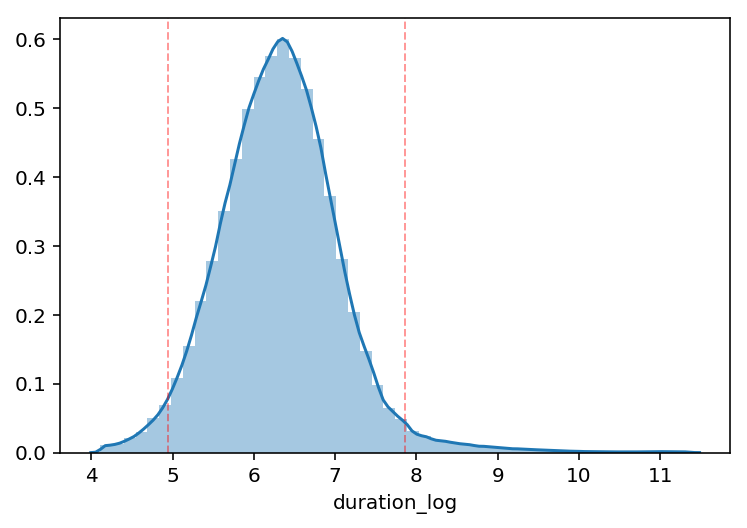

In [6]:
# because duration contains outliers let's plot it with logarithmic scale
bikeshare_df['duration_log'] = np.log(bikeshare_df.duration_sec)
ax = sns.distplot(bikeshare_df.duration_log)
ax.axvline(x=np.log(confidence[0]), linewidth=1, color='r', linestyle='--', alpha=0.4)
ax.axvline(x=np.log(confidence[1]), linewidth=1, color='r', linestyle='--', alpha=0.4);

Changing the __duration_sec__ to logarithm scale reveals that it is a bell shaped distribution with a tail to the right composed of some extreme outliers.

Plotting both the median and mean duration of bike rentals also shows that the dataset have some really large samples of duration.

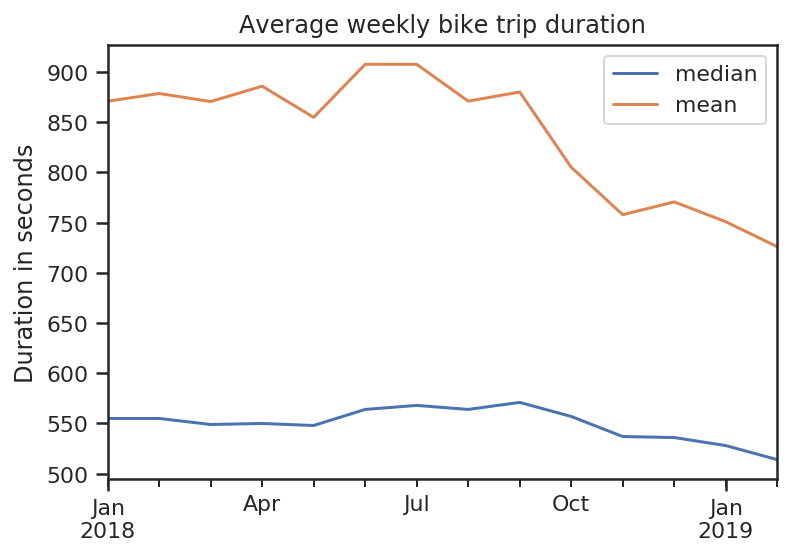

In [81]:
# generate monthly intervals and calculate median and mean for each interval 
ax = bikeshare_df[['start_time', 'duration_sec']]\
            .resample('M', on='start_time')['duration_sec']\
            .agg(['median', 'mean'])\
            .plot()
ax.set(xlabel='', ylabel='Duration in seconds', title='Average monthly bike trip duration');

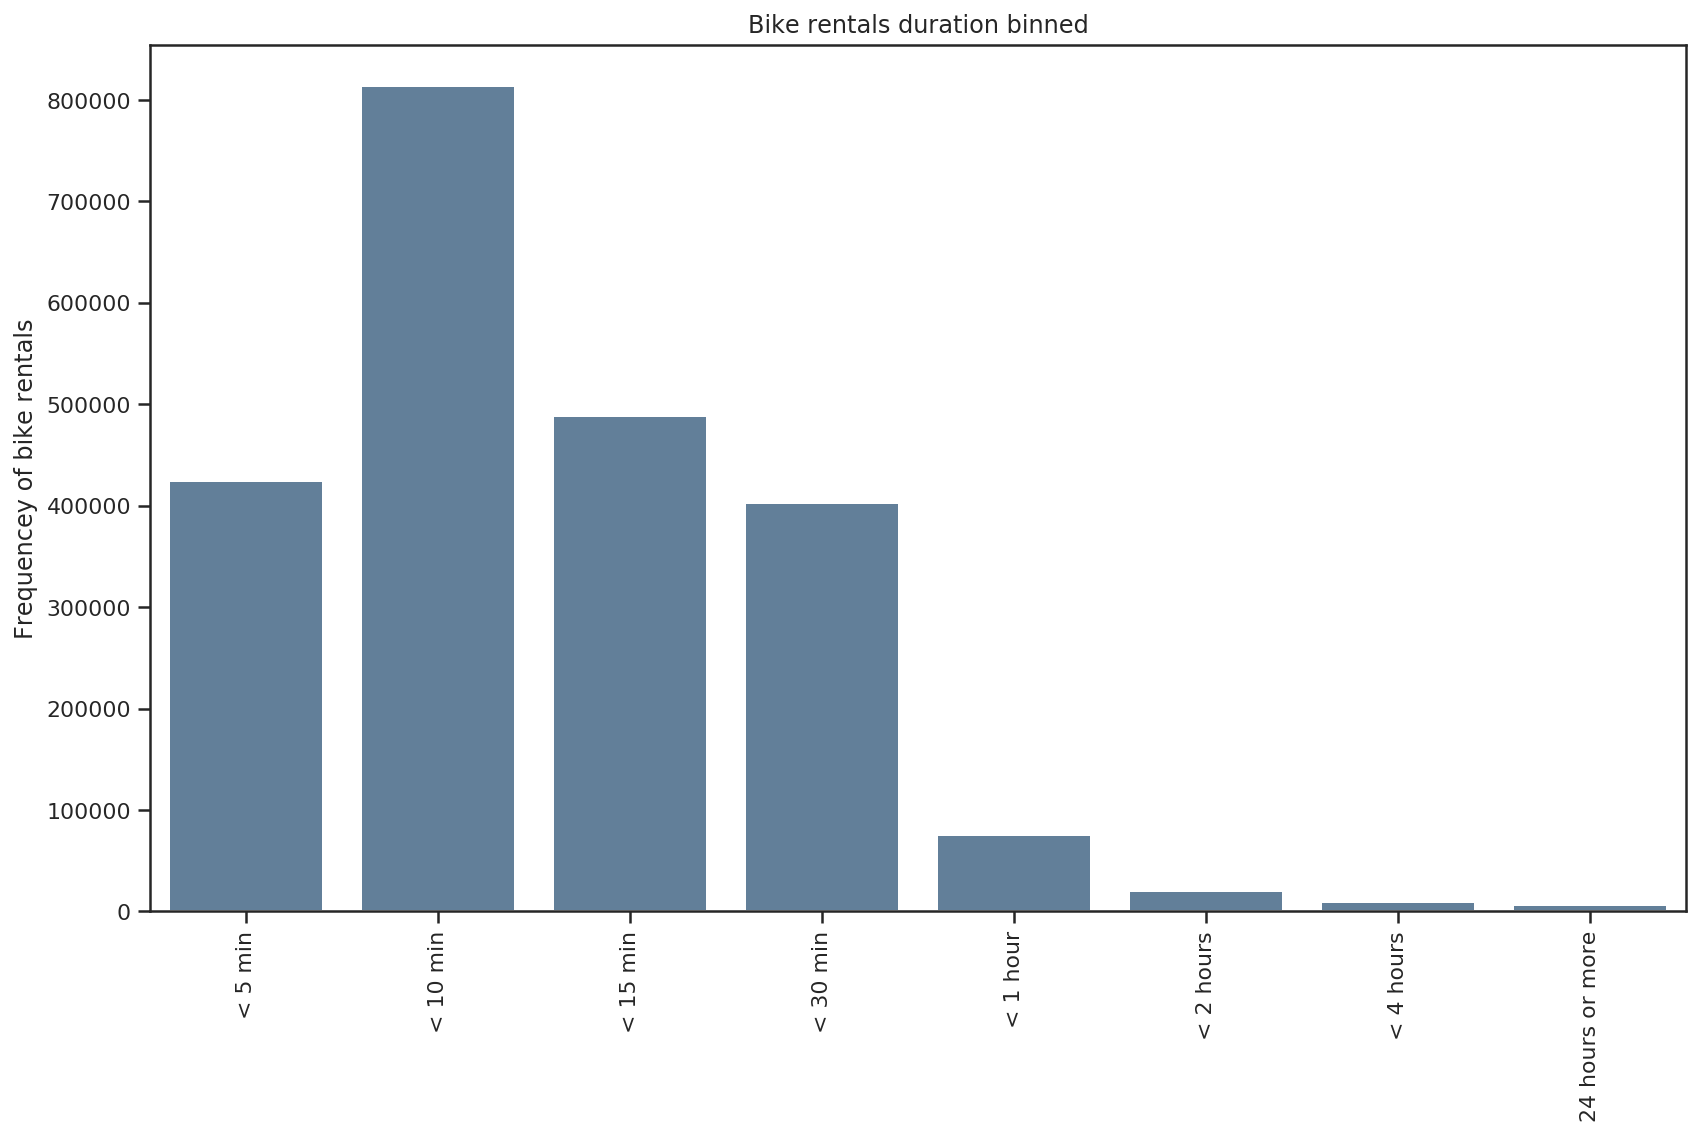

In [68]:
# cut the duration_sec into eight discrete intervals
# and count values for each interval then generate a bar plot.

bins = [0, 300, 600, 900, 1800, 3600, 7200, 14400, 86400]
labels = ['< 5 min', '< 10 min', '< 15 min', '< 30 min', '< 1 hour', '< 2 hours', '< 4 hours', '24 hours or more']

duration_quartiles = pd.cut(bikeshare_df['duration_sec'], bins=bins, labels=labels)
binned_duration = duration_quartiles.value_counts(sort=False)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(binned_duration.index, binned_duration, color='steelblue', saturation=0.5, ax=ax)
ax.set(title='Bike rentals duration binned', xlabel='', ylabel='Frequencey of bike rentals')
ax.tick_params(axis='x', labelrotation=90)


Dividing the __duration_sec__ into fixed bins of varings time frames, starting with 5 minutes intervalls, reveals that the most common bike usage is less than 10 minutes.

### 1.2. Bivariate Exploration

Exploring the __duration_sec__ against one of the __user_type__ or __start_time__ variables

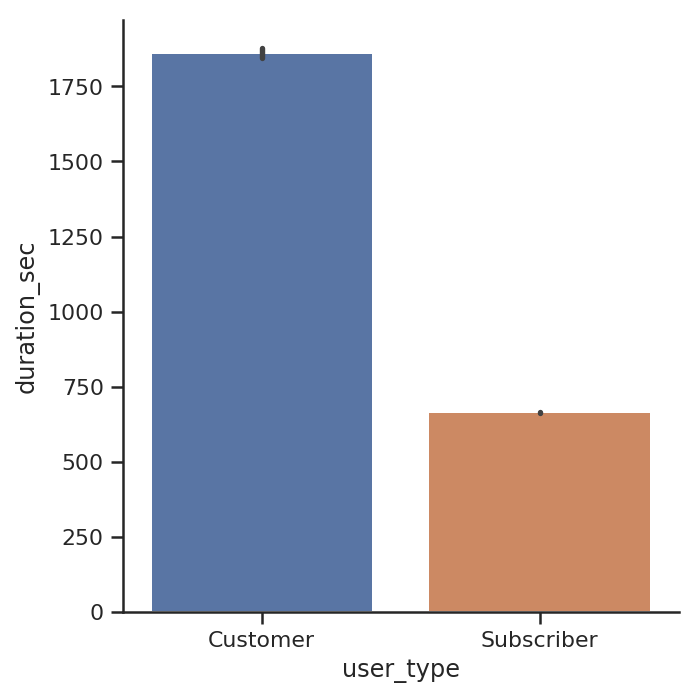

In [35]:
# draw barplot with the user types duration
sns.catplot(x='user_type', 
            y='duration_sec', 
            data=bikeshare_df, 
            kind='bar',
            color='steelblue')

Mean duration for bike rental is considerable larger for Customer than Subscriber user types.

In [20]:
# group weekday and user type and calculate descriptive statistics for duration

weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

userstart = bikeshare_df[['user_type', 'start_time', 'duration_sec', 'member_gender']].copy()
userstart['weekday'] = userstart.start_time.dt.weekday_name.astype('category', 
                                                                   categories=weekday_names, 
                                                                   ordered=True)
userstart.groupby(['weekday', 'user_type'])['duration_sec'].describe()

count         mean          std   min    25%     50%  \
weekday   user_type                                                             
Monday    Customer     39501.0  1760.946128  4754.978545  61.0  541.0   873.0   
          Subscriber  310566.0   646.779393  1205.827254  61.0  327.0   509.0   
Tuesday   Customer     40020.0  1679.956022  4813.984626  61.0  525.0   824.0   
          Subscriber  342463.0   642.839349  1227.004104  61.0  327.0   508.0   
Wednesday Customer     41123.0  1615.342533  4617.889736  61.0  529.0   825.0   
          Subscriber  340722.0   649.534844  1351.815628  61.0  327.0   510.0   
Thursday  Customer     44788.0  1639.468943  4675.586801  61.0  521.0   822.0   
          Subscriber  342981.0   649.077698  1292.615427  61.0  327.0   509.0   
Friday    Customer     47829.0  1746.743106  4767.190288  61.0  553.0   885.0   
          Subscriber  300287.0   657.538352  1306.918943  61.0  329.0   514.0   
Saturday  Customer     59726.0  2166.255935  5130.593042  61.0  676.0  1132.0   
          Subscriber  148315.0   757.192159  1674.660709  61.0  329.0   530.0   
Sunday    Customer     50398.0  2227.112504  5233.858105  61.0  670.0  1131.0   
          Subscriber  130496.0   756.123092  1701.865382  61.0  320.0   518.0   

                          75%      max  
weekday   user_type                     
Monday    Customer    1460.00  86003.0  
          Subscriber   769.00  86142.0  
Tuesday   Customer    1343.00  85546.0  
          Subscriber   767.00  86205.0  
Wednesday Customer    1326.00  85475.0  
          Subscriber   769.00  85444.0  
Thursday  Customer    1324.00  85983.0  
          Subscriber   769.00  85248.0  
Friday    Customer    1455.00  85788.0  
          Subscriber   775.00  85141.0  
Saturday  Customer    1796.75  86366.0  
          Subscriber   853.00  86281.0  
Sunday    Customer    1826.00  86208.0  
          Subscriber   843.00  85813.0

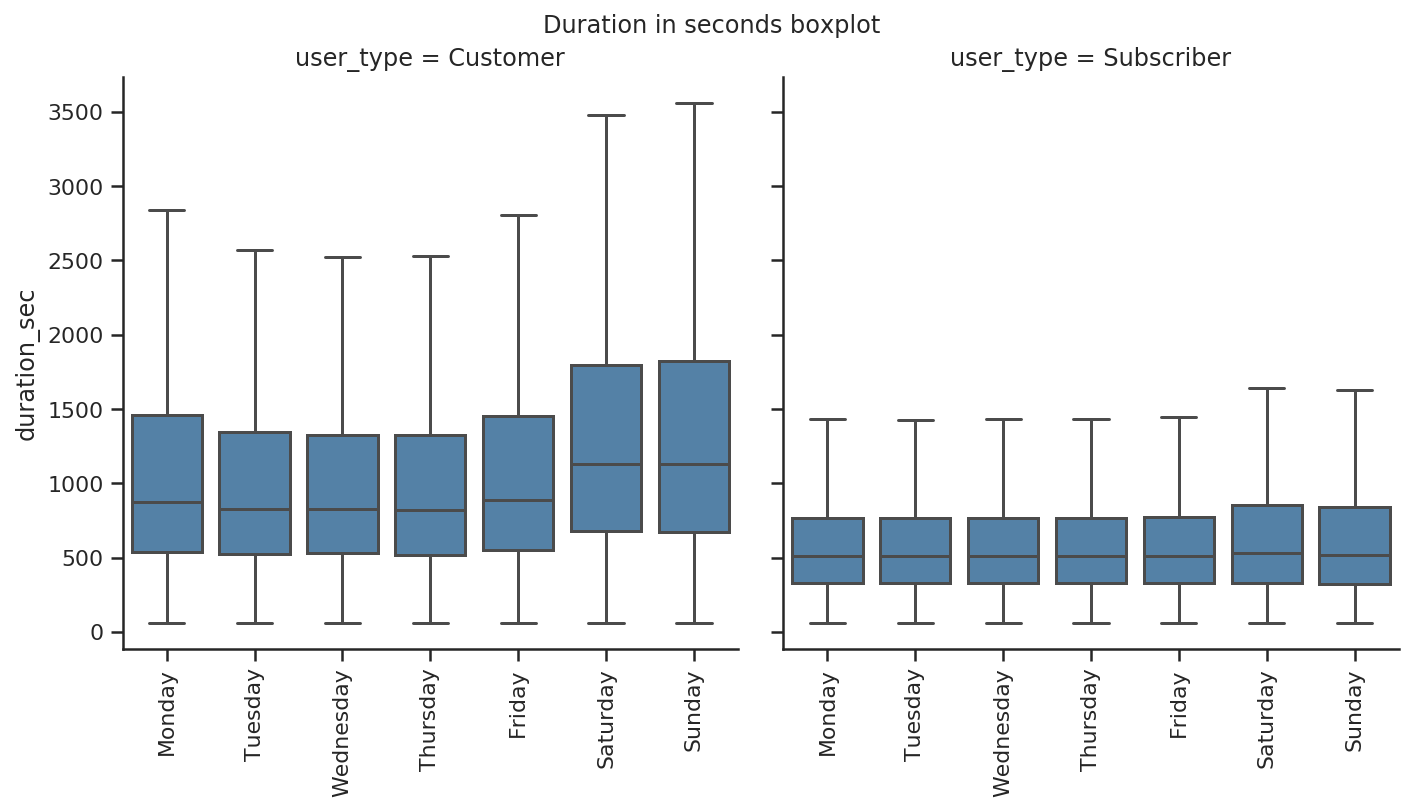

In [95]:
# Boxplots for each user type with no outlier symbol painted
# Rotate x labels vertical
g = sns.catplot(x='weekday', 
            y='duration_sec', 
            data=userstart, 
            col='user_type', 
            kind='box', 
            sym='',
            color='steelblue',
            order=weekday_names)

g.fig.suptitle('Duration in seconds boxplot', verticalalignment='bottom')
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

The bike trip duration for Subscribers is homogeneous for all business workdays with a slight increase for the weekend.

For the Customer user type the duration is higher in the weekend and Monday. Because the duration is also higher it seems that bike trips are more leisure.

### 1.3. Multivariate Exploration

Exploring the __duration_sec__, __user_type__ and __member_gender__ variables

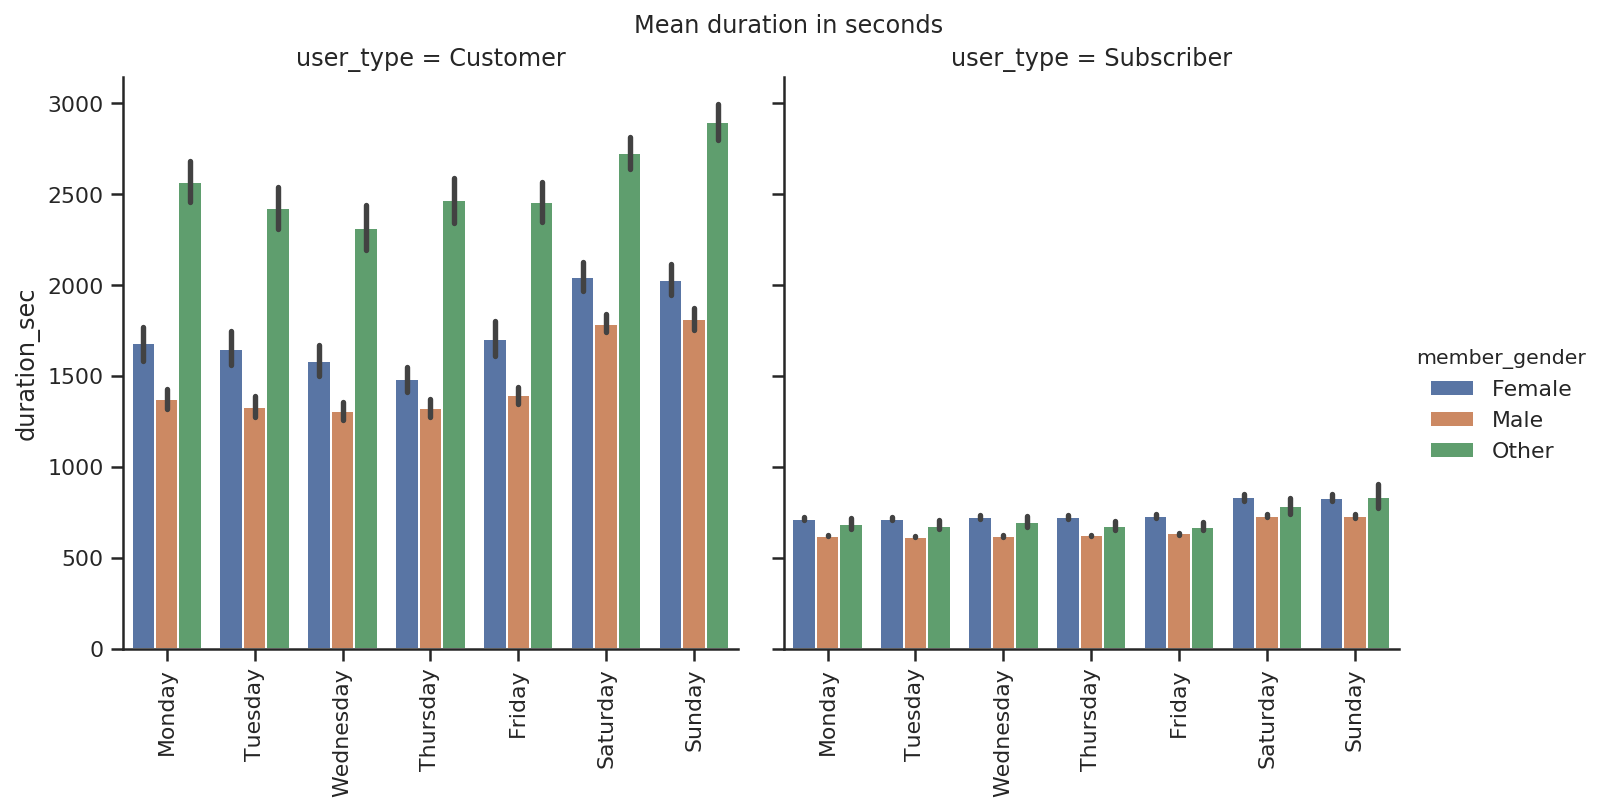

In [29]:
# Bar charts for each user types duration, partitioned into each member gender
# Rotate x labels vertical
g = sns.catplot(x='weekday', 
            y='duration_sec', 
            data=userstart, 
            col='user_type',
            hue='member_gender',
            kind='bar', 
            order=weekday_names)

g.fig.suptitle('Mean duration in seconds', verticalalignment='bottom')
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

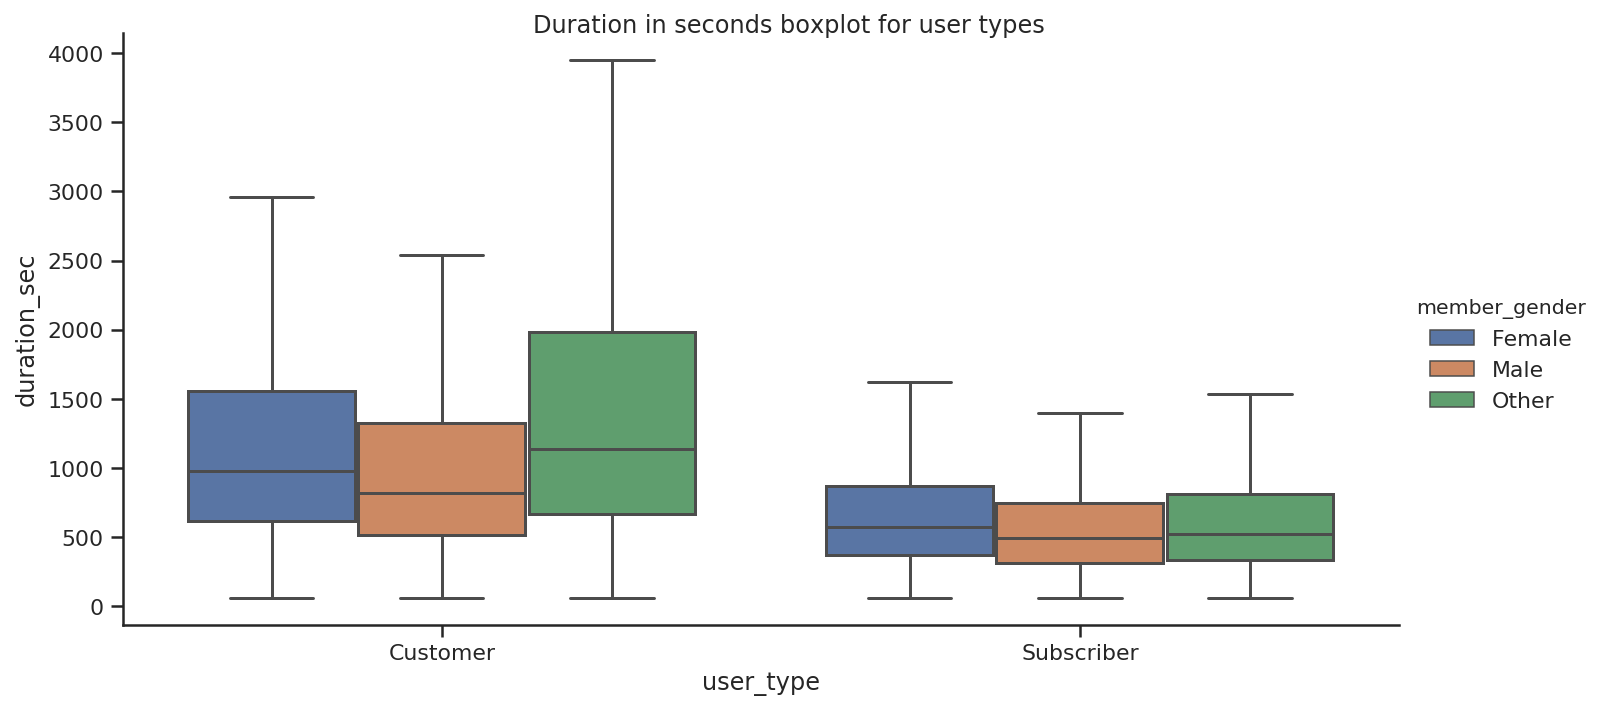

In [31]:
# Boxplots for each user types duration, partitioned into each member gender
g = sns.catplot(x='user_type', 
            y='duration_sec', 
            data=bikeshare_df, 
            hue='member_gender',
            kind='box', sym='', aspect=2)

g.fig.suptitle('Duration in seconds boxplot for user types');

The bike trip duration is homogenous for the Subscriber user type even when comparing against member gender.

There is less data for the Customer user type so the variability is greater in this group. That could be one of the reasons why members who don't want to categories themself to any gender have much wider Inter Quartile Range, IQR.

# 2. Exploring user type and member gender of bike rentals

## 2.1. Univariate Exploration

Start with exploring the __user_type__ variable

Explore distribution of categorical variables.

* What is the distribution of user types?
* What is the distribution of member gender?
* What is the distribution of bike share for all trip?

Customer:   0.144 percentage
Subscriber: 0.856 percentage


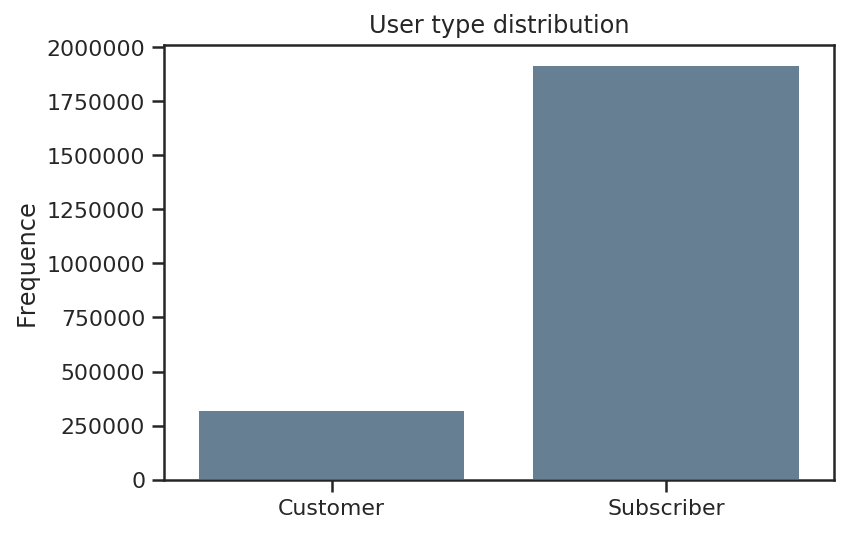

In [41]:
# count each user type and calculate percentage of distribution
# and present a bar chart with the counted sum for each user type 

user_types = bikeshare_df.user_type.value_counts()
print(f"Customer:   {user_types['Customer'] / len(bikeshare_df):.3f} percentage")
print(f"Subscriber: {user_types['Subscriber'] / len(bikeshare_df):.3f} percentage")

ax = sns.countplot(x='user_type', 
              data=bikeshare_df, 
              color='steelblue', 
              saturation=0.4)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='User type distribution');

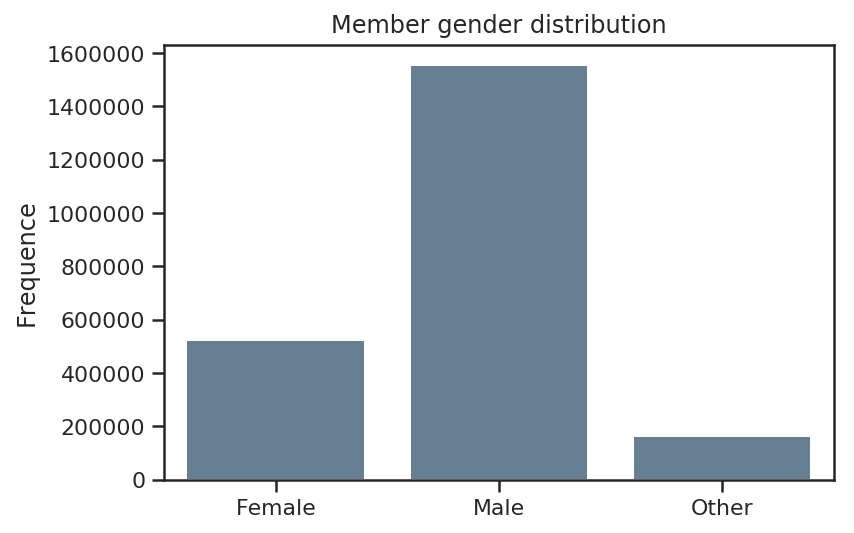

In [42]:
# bar chart with the counted sum for each member gender
ax = sns.countplot(x='member_gender', 
              data=bikeshare_df, 
              color='steelblue', 
              saturation=0.4)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='Member gender distribution');

### 2.2. Bivariate Exploration

Exploring the __user_type__ against the __member_gender__ variable.

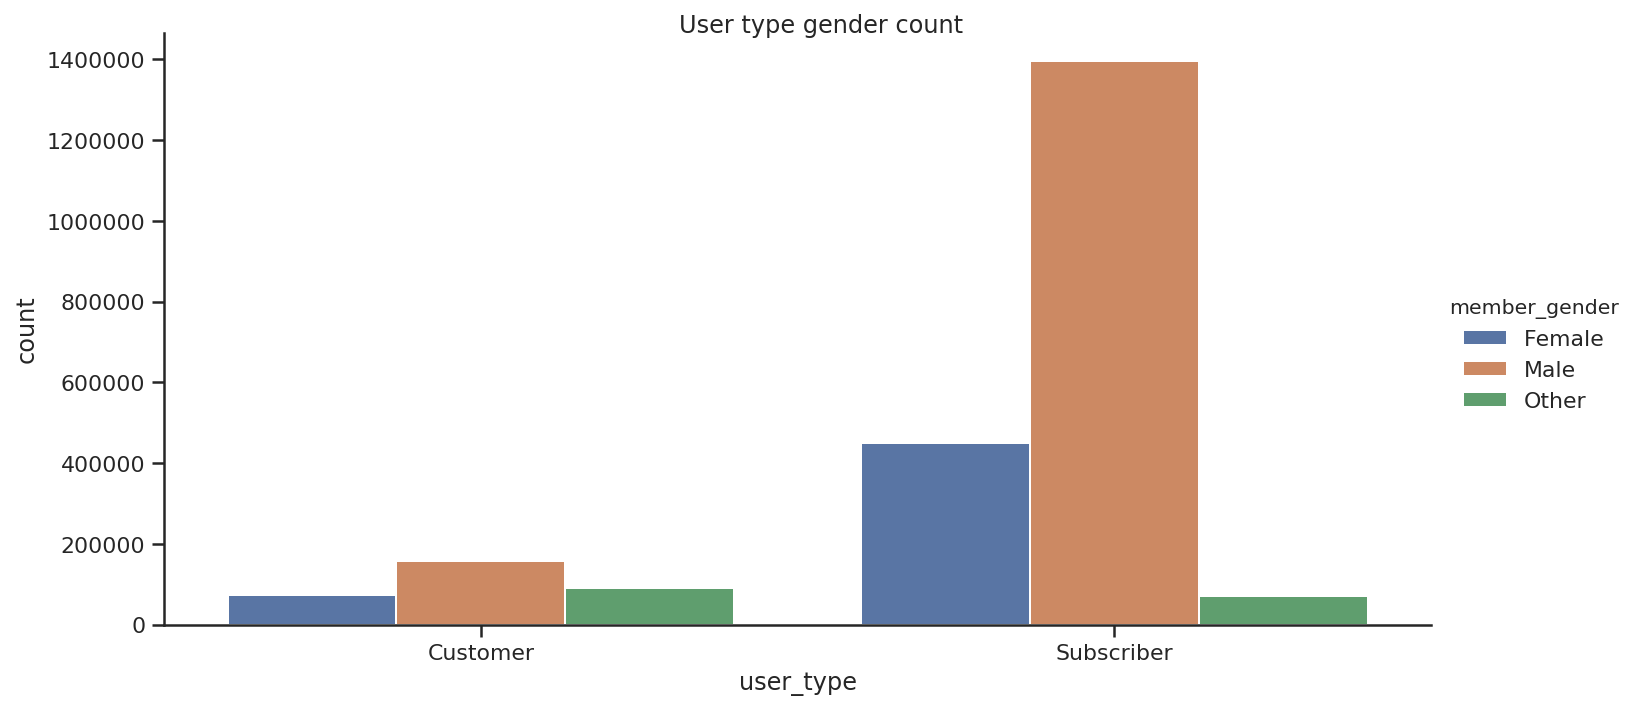

In [33]:
# bar char with the counted sum for each user type partitioned into member gender
g = sns.catplot(x='user_type', 
                hue='member_gender', 
                data=bikeshare_df, 
                kind='count', 
                aspect=2)

g.fig.suptitle('User type gender count');

The distribution is quite distinct for the two categorical variables. 
Bike rentals is mostly done by a subscriber that is male.

### 2.3. Multivariate Exploration

Combining the tree categorical variables does it reveal any other pattern?

But first explore the distribution of __bike_share_for_all_trip__ variable.

First occurence of a Bike share for all trip: 2018-01-01


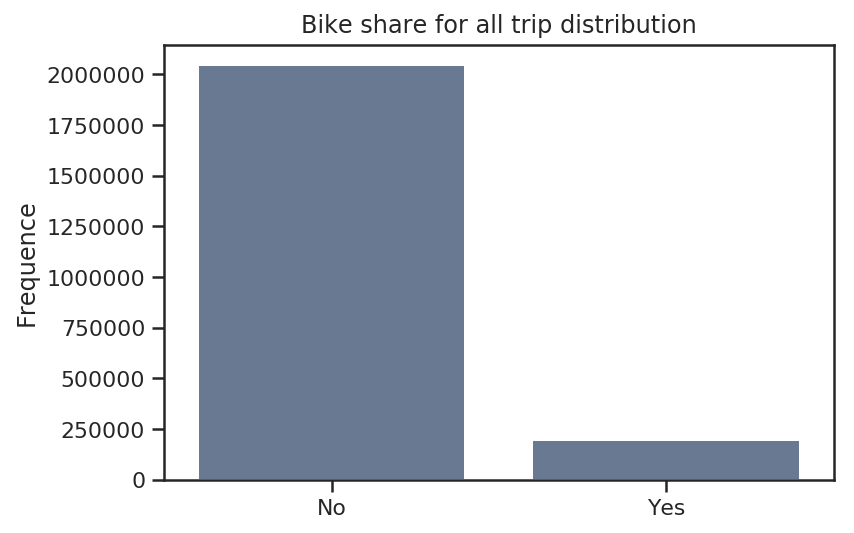

In [29]:
# bar chart with the counted sum for the binary variable bike_share_for_all_trip

print('First occurence of a Bike share for all trip:', 
      bikeshare_df[bikeshare_df.bike_share_for_all_trip == 'Yes']['start_time'].min().strftime('%Y-%m-%d'))

ax = sns.countplot(x='bike_share_for_all_trip', 
              data=bikeshare_df, 
              color='b', 
              saturation=0.4)

ax.set(xlabel='', ylabel='Frequence', title='Bike share for all trip distribution');

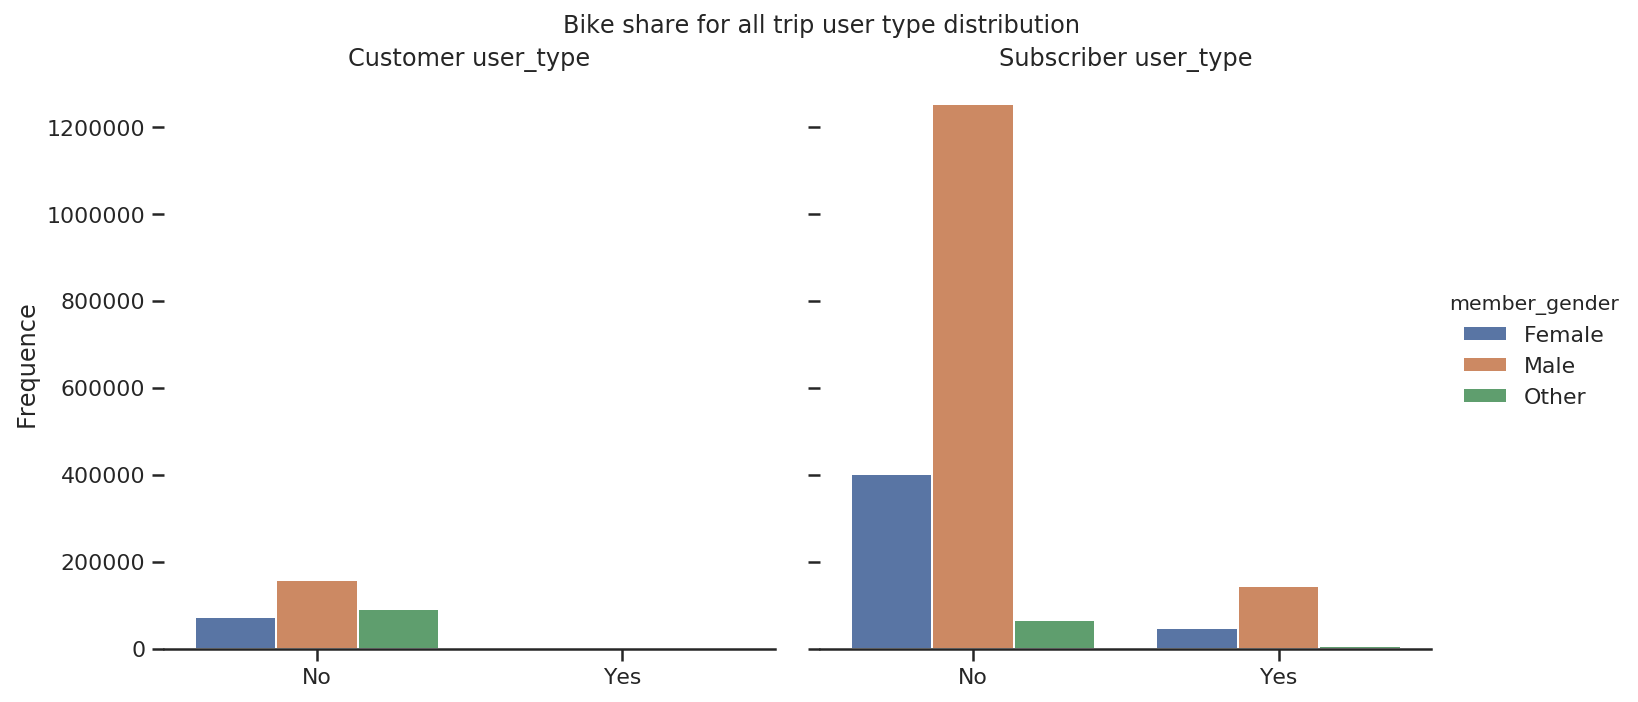

In [25]:
# bar charts for each user type with the counted sum for the binary variable bike_share_for_all_trip
# and now partitioned over each member gender
g = sns.catplot(x='bike_share_for_all_trip',
                hue='member_gender', 
                col='user_type', 
                data=bikeshare_df, 
                kind='count')

g.fig.suptitle('Bike share for all trip user type distribution', verticalalignment='bottom')
g.set_axis_labels("", "Frequence")\
    .set_titles("{col_name} {col_var}")\
    .despine(left=True);

Plotting the three variables __user_type__, __member_gender__, and __bike_share_for_all_trip__ shows that no Customer have been on any bike trip for this program. I don't know what the requirements are? Perhaps they don't qualify?

In the Subscriber user type there are not so many bike trips that have been an __bike_share_for_all_trip__ and the gender distribution seems to be proportional between Female and Male.

# 3. Exploring bike rentals start time

### 3.1. Univariate Exploration

Start with exploring weekday from the  __start_time__ variable


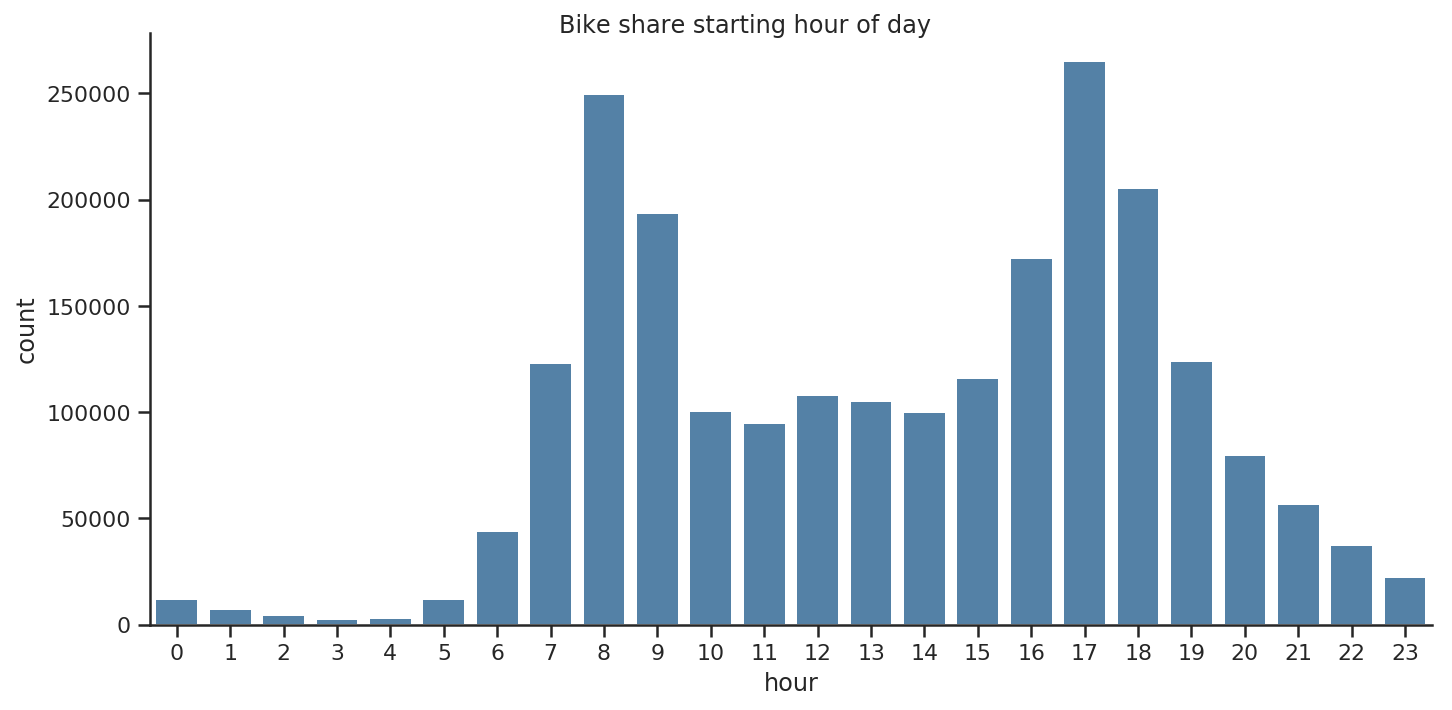

In [61]:
# introduce hour variable and draw bar chart with the counted sum for each hour of the day

userstart['hour'] = userstart.start_time.dt.hour

g = sns.catplot(x='hour',
                data=userstart,
                kind='count',
                color='steelblue',
                aspect=2)

g.fig.suptitle('Bike share starting hour of day');

From the two spikes at 8 and 17 o'clock I interpret that as people communting to work that utilize the bikes heavely. 

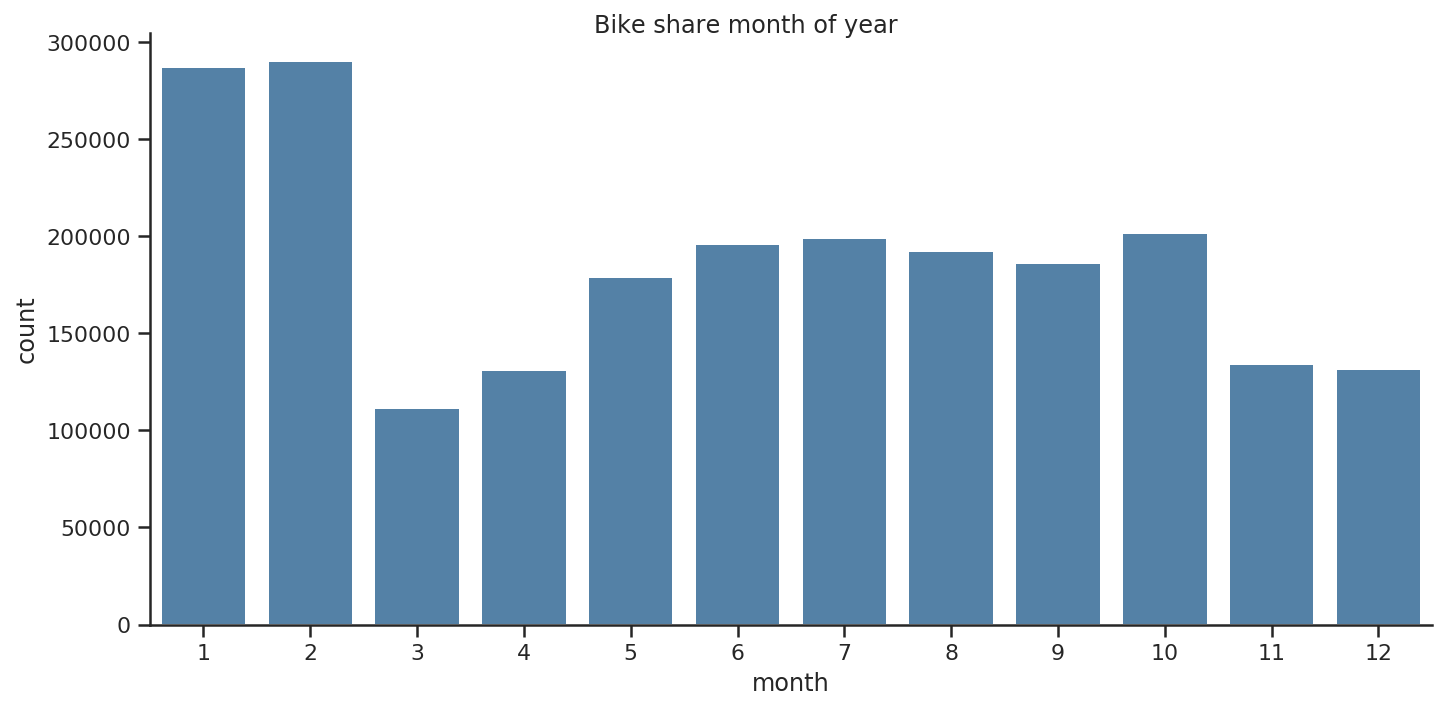

In [45]:
# introduce month variable and draw bar char with the counted sum for each month of the year

userstart['month'] = userstart.start_time.dt.month

g = sns.catplot(x='month',
                data=userstart,
                kind='count',
                color='steelblue',
                aspect=2)

g.fig.suptitle('Bike share month of year');

I don't know why there are inter seasonal variations. Perhaps the January and February spike is due to people have given new years resolution to live a healthier life? Then in March the motivation to ride bikes drops.

## 3.2. Bivariate Exploration

Exploring weekday from the  __start_time__  for hour of day and month against the __user_type__ variable.

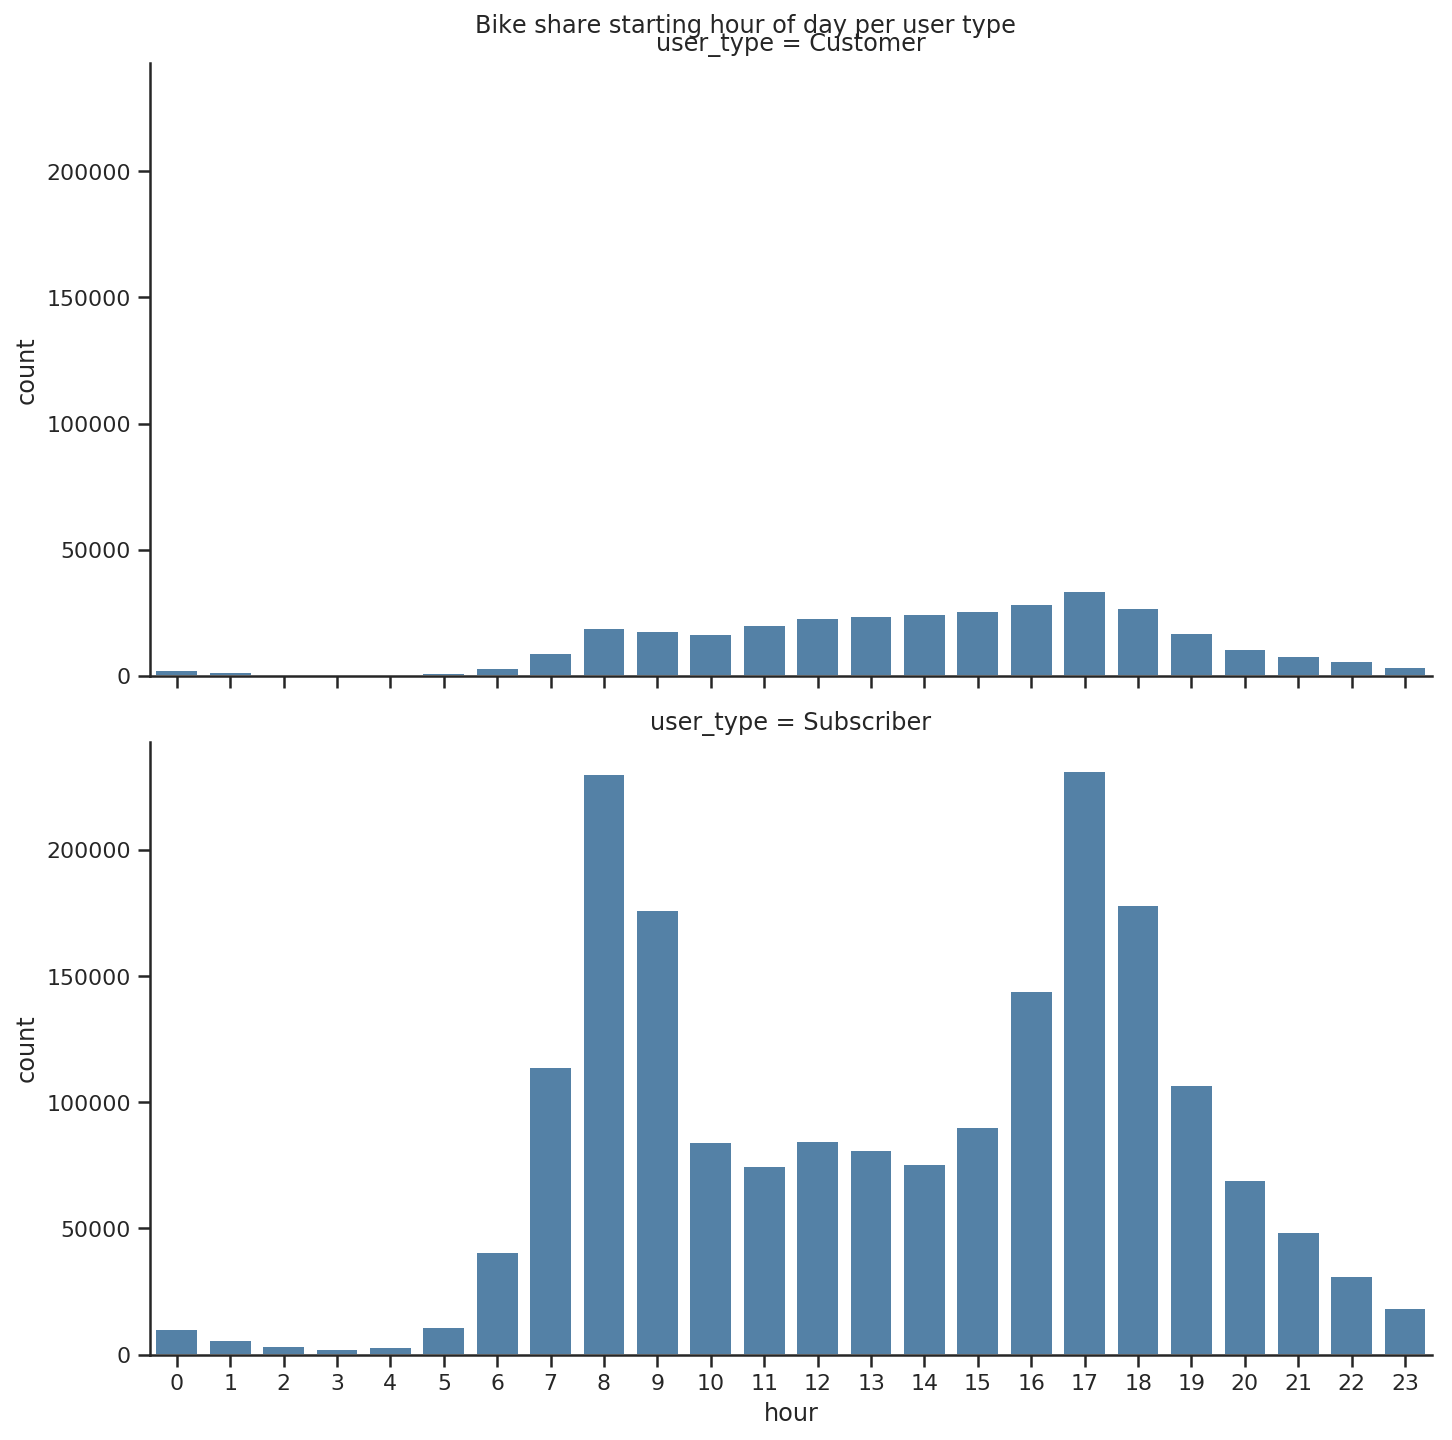

In [91]:
# bar charts for each user type that shows counted sum for hours of the day
g = sns.catplot(x='hour', 
            row='user_type', 
            data=bikeshare_df, 
            kind='count', 
            color='steelblue',
            aspect=2)

g.fig.suptitle('Bike share starting hour of day per user type', verticalalignment='bottom');

There is clearly different patterns between the two user types. Where the Subscribers hava two spikes during the day. The Customers have a much smoother almost flat usage pattern between 8 and 19 o'clock. There is a slight increase toward later in the afternoon for Customers.

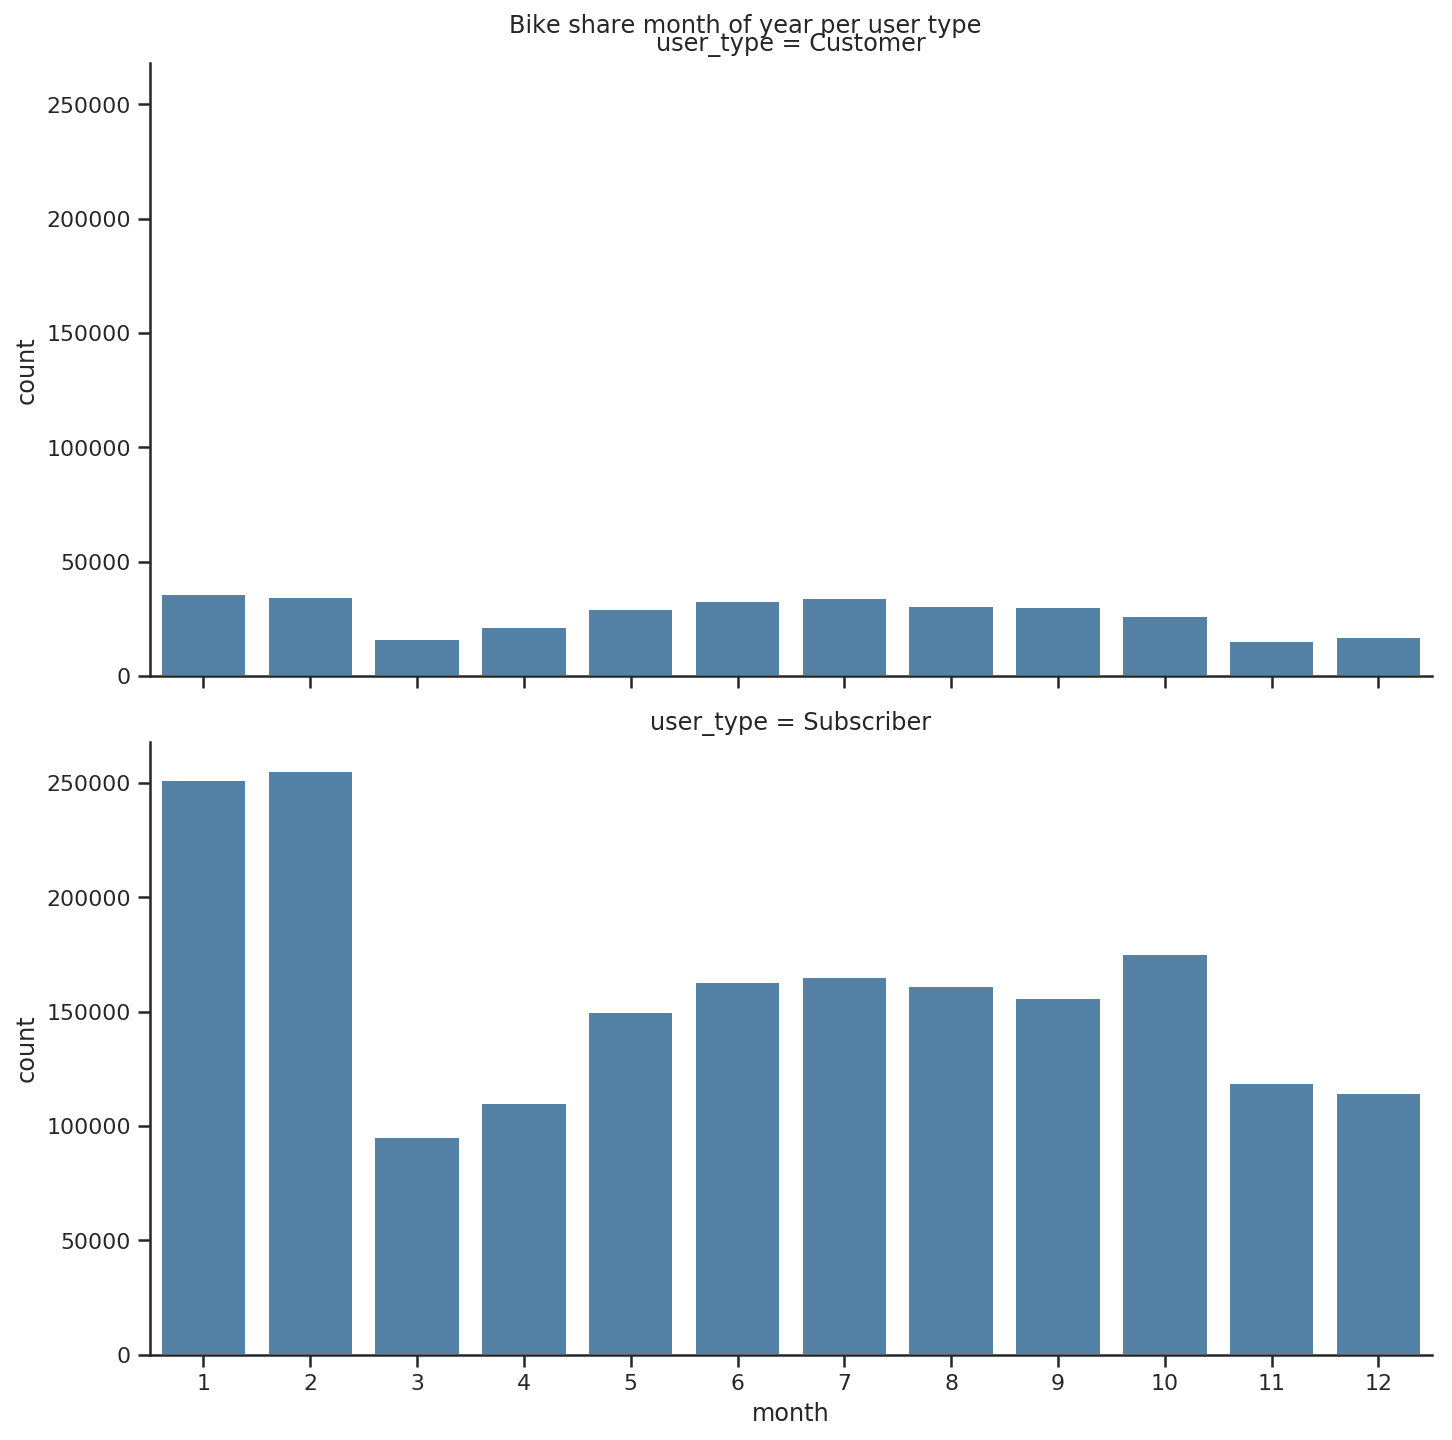

In [92]:
# bar charts for each user type that show counted sum for months of the year
g = sns.catplot(x='month', 
            row='user_type', 
            data=bikeshare_df, 
            kind='count', 
            color='steelblue',
            aspect=2)

g.fig.suptitle('Bike share month of year per user type', verticalalignment='bottom');

The frequency of bike rentals is higher on weekends than in business weekdays.

## 3.3. Multivariate Exploration

Exploring the  __start_time__ with day of the week and if the start hour is afternoon against the __user_type__ variable.

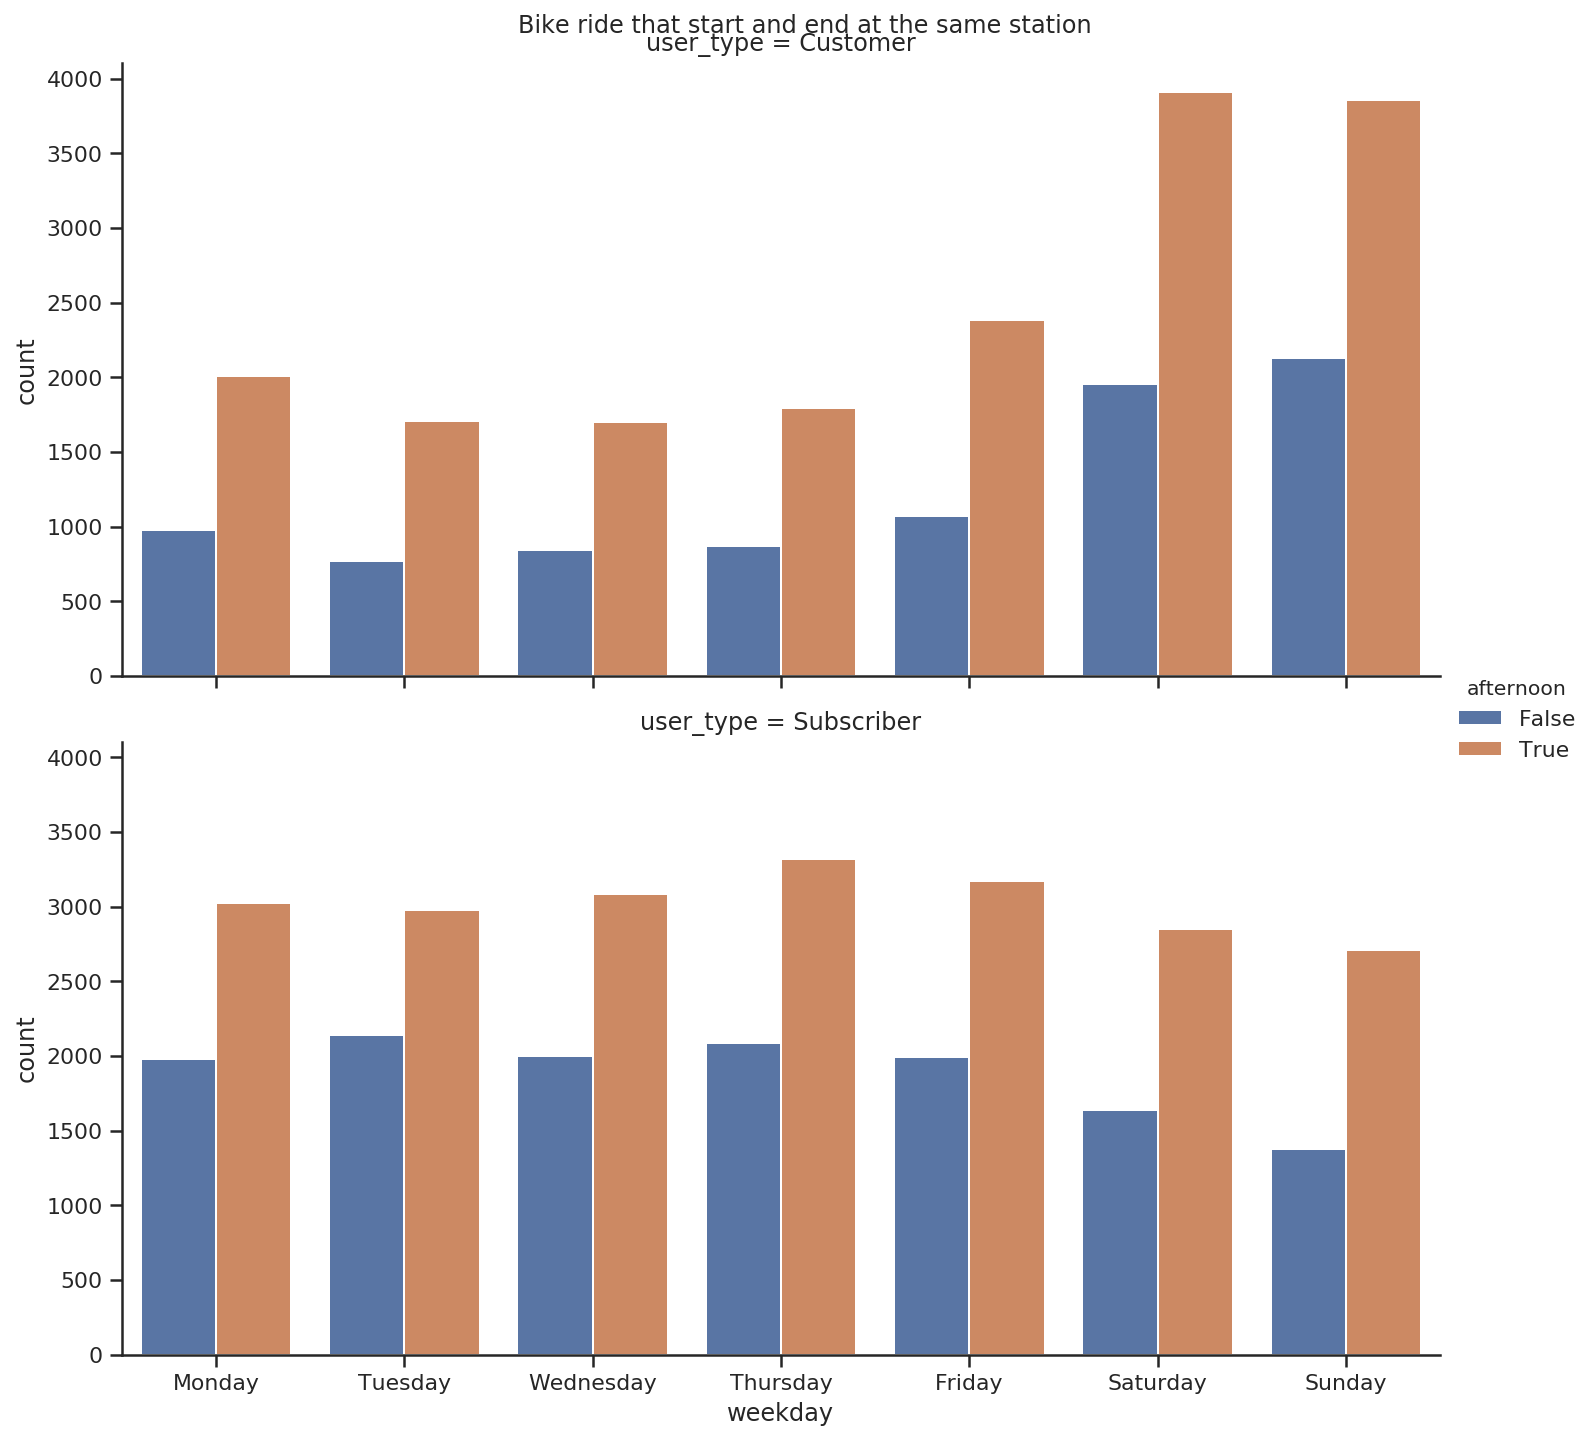

In [100]:
# filter stations that are same for both start and end
# introduce two new columns with weekday and part of day

# bar charts for each user type then count occurrences of weekday, then partition over part of day

same_station = bikeshare_df[bikeshare_df.start_station_id == bikeshare_df.end_station_id].copy()
same_station['weekday'] = same_station.start_time.dt.weekday_name
same_station['afternoon'] = same_station.start_time.dt.hour.apply(lambda x: x > 12)

g = sns.catplot(x='weekday', 
            row='user_type', 
            hue='afternoon', 
            data=same_station, 
            order=weekday_names, 
            kind='count', 
            aspect=2)

g.fig.suptitle('Bike ride that start and end at the same station', verticalalignment='bottom');

Bike rental trips that have the same start and end station seems to occur mostly on the weekend and the casual Customer user type is responsible for the incease

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I started off exploring with a pairplot. But that was really busy and I did not see any clear trends in the data from that plot.

Then I started exploring the __duration_sec__ variable and that was not very useful as a univariate plot. When performing a bivariate plot with weekday the data showed that there are different bike rental usage patterns during weekdays.

The exploration of user types and gender revealed that Male Subscriber is the most likely bike rider.

Ended the exploration with the __start_time__ and investigate during which hours during the day bikes are used most. Then also during what months of the year.


### Were there any interesting or surprising interactions between features?

That it was such a strong visible trend that Subscribers utilize bikes during two distinct hours each day. And that the casual Customer user type have a increase usage of bikes during the weekends.